In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import distr
import common
import multiprocessing

In [3]:
import gaussian

In [4]:
PHI_RANGE     = [ 0.,6.]
THETA_RANGE   = [-2.,2.]
DATA_RANGE    = [-5.,5.] 
THE_SIMULATOR = gaussian.simulator
MODEL_NAME = 'gaussian'

In [5]:
model_details_shifts = [-10.,10.]
model_details_mirror = False
model_details_lnlike_nsim = 1000
model_details_map_bins = 20

In [6]:
intro_theta_nom = 0.0
intro_phi_noms  = math.pi,math.pi/2.
intro_binning   = 51

example_phi = math.pi/2.
example_theta = 1.
example_ndata = 100

# Introducing the Model p(x|$\theta$,$\Phi$)

..................

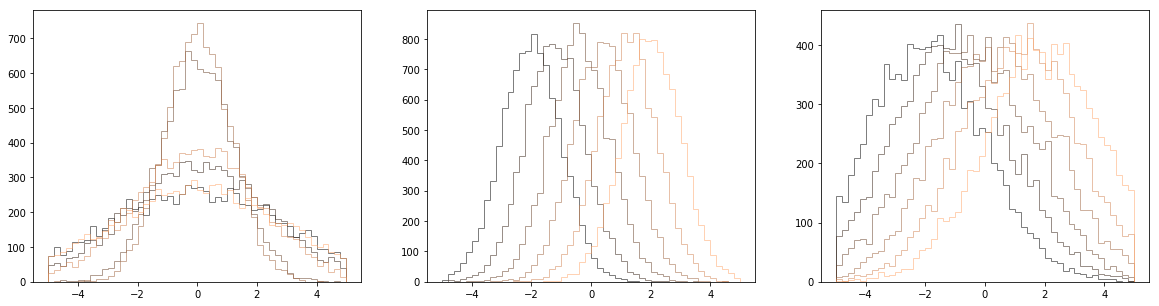

In [7]:
cm = plt.get_cmap('copper')
fig,axarr = plt.subplots(1,3)
fig.set_size_inches(20,5)
bins = np.linspace(*DATA_RANGE, num = intro_binning)

nsteps_phi, theta_nom = 6, intro_theta_nom
for i,phi in enumerate(np.linspace(*PHI_RANGE,num = nsteps_phi)):
    _=axarr[0].hist(THE_SIMULATOR(theta_nom,phi,10000), bins = bins, color = cm(i/float(nsteps_phi)), alpha = 0.5, histtype='step')

nsteps_theta, phi_nom = 6, intro_phi_noms[0]
for i,theta in enumerate(np.linspace(*THETA_RANGE,num = nsteps_theta)):
    _=axarr[1].hist(THE_SIMULATOR(theta,phi_nom,10000), bins = bins, color = cm(i/float(nsteps_phi)), alpha = 0.5, histtype='step')
    
nsteps_theta, phi_nom = 6, intro_phi_noms[1]
for i,theta in enumerate(np.linspace(*THETA_RANGE,num = nsteps_theta)):
    _=axarr[2].hist(THE_SIMULATOR(theta,phi_nom,10000), bins = bins, color = cm(i/float(nsteps_phi)), alpha = 0.5, histtype='step')
    
plt.savefig('{}_intro.pdf'.format(MODEL_NAME))
plt.savefig('{}_intro.pdf'.format(MODEL_NAME))

# An Example Experiment
## Taking Data

...

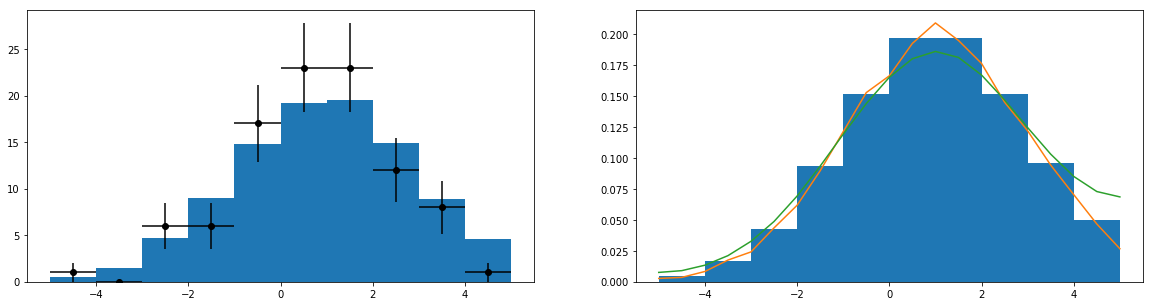

In [8]:
fig,axarr = plt.subplots(1,2)
fig.set_size_inches(20,5)


bins = np.linspace(*DATA_RANGE, num = 11)
example_data = common.collect_data(example_phi,THE_SIMULATOR, theta_nature=example_theta, n_samples = example_ndata)
datacounts,bins = np.histogram(example_data,bins = bins)
centers = bins[:-1] + (bins[1:]-bins[:-1])/2.
axarr[0].errorbar(centers,datacounts,fmt = 'o',xerr = (bins[1:]-bins[:-1])/2.,yerr = np.sqrt(datacounts), c = 'k')

n_mc = 10000
mc = THE_SIMULATOR(example_theta,example_phi,n_mc) #simulate much more than data
mccounts,_,_ = axarr[0].hist(mc,weights = [float(example_ndata)/float(n_mc)]*n_mc, bins = bins)

####

samples = THE_SIMULATOR(example_theta,example_phi,n_mc)
p = distr.Distribution(
    name = 'example_simulation',
    samples = samples,
    range = DATA_RANGE)

p.hist(bins = 10, normed = True,ax = axarr[1])

xs = np.linspace(*DATA_RANGE,num = 21)
logpdf_nomirr = p.approx_logpdf()
logpdf_mirror = p.approx_logpdf(mirror = True, mirror_shifts=model_details_shifts)

axarr[1].plot(xs,np.exp(logpdf_nomirr(xs)))
axarr[1].plot(xs,np.exp(logpdf_mirror(xs)))

plt.savefig('{}_data.pdf'.format(MODEL_NAME))
plt.savefig('{}_data.pdf'.format(MODEL_NAME))

## The likelihood $p(x|\theta,\Phi)$ and the prior $p(\theta|\Phi)$

......

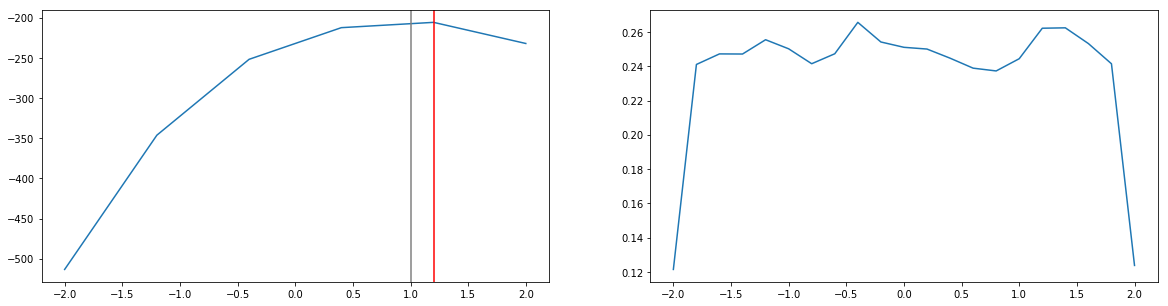

In [9]:
test_thetas = np.linspace(*THETA_RANGE,num = 6)
pool = multiprocessing.Pool(4)


nll = [pool.apply_async(common.lnlike,
                        args = (theta_test,example_data,example_phi),
                        kwds = dict(
                         simulator=THE_SIMULATOR,
                         simulation_kwargs = {'n_samples': model_details_lnlike_nsim},
                         distr_kwargs =  {'range': DATA_RANGE},
                         logpdf_kwargs = {'mirror': model_details_mirror, 'mirror_shifts': model_details_shifts}
                        )
                       ) for theta_test in test_thetas]
[r.ready() for r in nll]

pool.close()
pool.join()
nll = [r.get() for r in nll]

fig,axarr = plt.subplots(1,2)
fig.set_size_inches(20,5)

axarr[0].plot(test_thetas,nll)
axarr[0].axvline(example_theta, c = 'grey') #truth
axarr[0].axvline(test_thetas[np.argmax(nll)], c = 'r') #max NLL


example_prior = distr.Distribution('prior',range = THETA_RANGE)
xs = np.linspace(*THETA_RANGE,num = 21)
logpdf = example_prior.approx_logpdf()
axarr[1].plot(xs,np.exp(logpdf(xs)))


plt.savefig('{}_likli.pdf'.format(MODEL_NAME))
plt.savefig('{}_likli.pdf'.format(MODEL_NAME))

## The posterior $p(\theta|x,\Phi)$

In [10]:
example_posterior = common.calculate_posterior(
    example_prior,example_data,example_phi,
    lnprob_args = dict(simulator = THE_SIMULATOR,
                       simulation_kwargs = {'n_samples': model_details_lnlike_nsim},
                       distr_kwargs =  {'range': DATA_RANGE},
                       logpdf_kwargs = {'mirror': model_details_mirror, 'mirror_shifts': model_details_shifts}
                  ),
    n_chainlen = 50
)

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

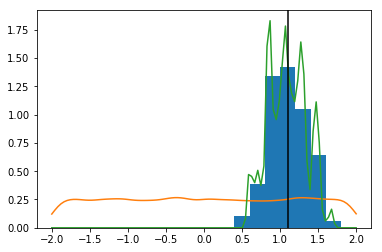

In [11]:
xs = np.linspace(*THETA_RANGE,num = model_details_map_bins+1)
example_posterior.hist(bins = model_details_map_bins,normed = True)
example_prior.plot()
example_posterior.plot()
example_best_theta = example_posterior.map(bins = model_details_map_bins)
plt.axvline(example_best_theta, c = 'k')

plt.savefig('{}_post.pdf'.format(MODEL_NAME))
plt.savefig('{}_post.pdf'.format(MODEL_NAME))

## Designing the next Experiment

## simple grid search

In [12]:
emcee_kwargs = dict(
    n_chainlen = 30,
    lnprob_args = dict(simulator = THE_SIMULATOR,
                       simulation_kwargs = {'n_samples': model_details_lnlike_nsim},
                       distr_kwargs =  {'range': DATA_RANGE},
                       logpdf_kwargs = {'mirror': model_details_mirror, 'mirror_shifts': model_details_shifts}
                      ),
)
eig_kwargs = dict(emcee_kwargs = emcee_kwargs, sim_n_data = example_ndata, map_bins = model_details_map_bins)

# for x in eig_test_phis.reshape(-1,1):
#     eig.append(common.expected_information_gain(x,example_posterior, emcee_kwargs = emcee_kwargs,))


res_sg = common.design_next_experiment_simplegrid(example_posterior,PHI_RANGE,eig_kwargs)

EIG [ 0.]
simulating with  1.1 0.0
simulating with  1.1 0.0
simulating with  1.1 0.0
simulating with  1.1 0.0
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

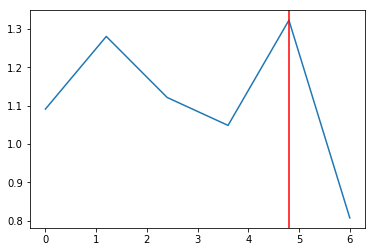

In [23]:
example_next_phi = res_sg[0]
def plot_simple_grid(res, ax = plt):
    ax.plot(res[1],res[2])
    ax.axvline(res[0], c = 'r')
plot_simple_grid(res_sg)

plt.savefig('{}_next_grid.pdf'.format(MODEL_NAME))
plt.savefig('{}_next_grid.pdf'.format(MODEL_NAME))

## designing next experiment via bayesian optimization and GPs

In [14]:
emcee_kwargs = dict(
    n_chainlen = 50,
    lnprob_args = dict(simulator = THE_SIMULATOR,
                       simulation_kwargs = {'n_samples': 3000},
                       distr_kwargs =  {'range': DATA_RANGE},
                       logpdf_kwargs = {'mirror': model_details_mirror, 'mirror_shifts': model_details_shifts}
                      )
)

eig_kwargs = dict(emcee_kwargs = emcee_kwargs, sim_n_data = example_ndata,map_bins = model_details_map_bins)
res_gp = common.design_next_experiment_bayesopt(example_posterior,PHI_RANGE,eig_kwargs, n_totalcalls = 7)

EIG [5.8021790340820605]
simulating with  1.1 5.80217903408
simulating with  1.1 5.80217903408
simulating with  1.1 5.80217903408
simulating with  1.1 5.80217903408
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

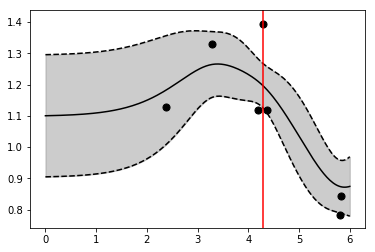

In [16]:
def plot_bayes(res,ax=plt):
    smooth_phi = np.linspace(*PHI_RANGE,num = 200).reshape(-1,1)
    y,std = res[0].models[-1].predict(smooth_phi, return_std = True)
    y,std = -y,-std
    ax.plot(smooth_phi[:,0],y, c = 'k')
    ax.plot(smooth_phi[:,0],y+std, c = 'k', linestyle = 'dashed')
    ax.plot(smooth_phi[:,0],y-std, c = 'k', linestyle = 'dashed')
    ax.fill_between(smooth_phi[:,0],y-std,y+std, color = 'k', alpha = 0.2)
    ax.scatter(res[0].x_iters,-res[0].func_vals, marker = '.', s = 200, color = 'k')
    ax.axvline(res[0].x, c = 'r')
plot_bayes(res_gp)

plt.savefig('{}_next_bayes.pdf'.format(MODEL_NAME))
plt.savefig('{}_next_bayes.pdf'.format(MODEL_NAME))

## The expected improvement in $\theta$

In [17]:
new_data_expected = common.collect_data(example_next_phi,THE_SIMULATOR,theta_nature=example_best_theta, n_samples = example_ndata)
example_exp_posterior = common.calculate_posterior(
    example_posterior,new_data_expected,example_next_phi,
    lnprob_args = dict(simulator = THE_SIMULATOR,
                       simulation_kwargs = {'n_samples': model_details_lnlike_nsim},
                       distr_kwargs =  {'range': DATA_RANGE},
                       logpdf_kwargs = {'mirror': model_details_mirror, 'mirror_shifts': model_details_shifts}
                  ),
    n_chainlen = 50
)

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

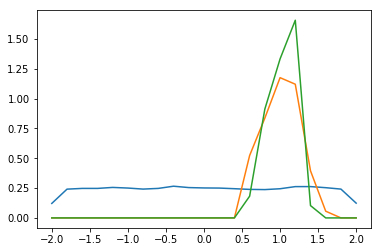

In [18]:
xs = np.linspace(*THETA_RANGE,num = 21)
logpdf_prior = example_prior.approx_logpdf()
logpdf_postr = example_posterior.approx_logpdf()
logpdf_exp_postr = example_exp_posterior.approx_logpdf()
plt.plot(xs,np.exp(logpdf_prior(xs)))
plt.plot(xs,np.exp(logpdf_postr(xs)))
plt.plot(xs,np.exp(logpdf_exp_postr(xs)))

## The whole story for a single 'science iteration'

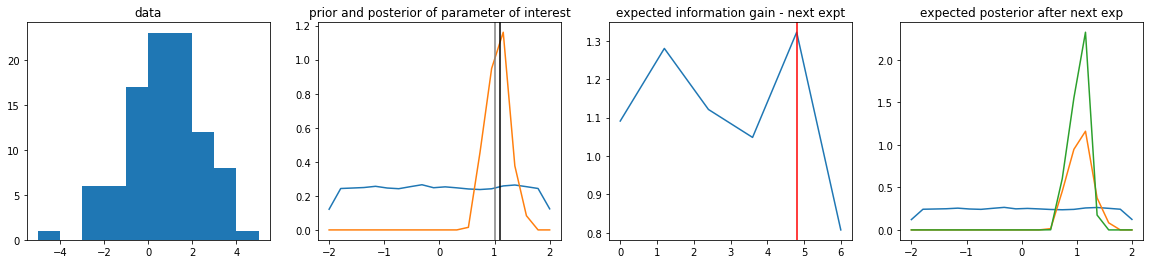

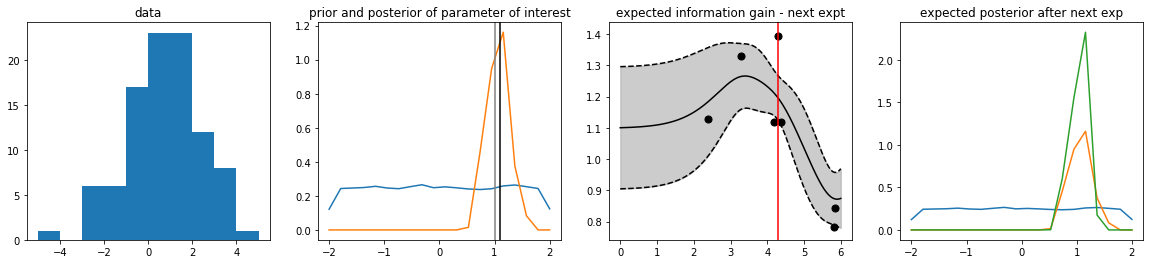

In [27]:
def summary_plot(data,prior,posterior,best_theta,true_theta,res,expected_posterior,res_type = 'simple'):
    fig,axarr = plt.subplots(1,4)
    fig.set_size_inches(20,4)
    bins = np.linspace(*DATA_RANGE, num = 11)
    axarr[0].hist(data, bins = bins)
    axarr[0].set_title('data')


    xs = np.linspace(*THETA_RANGE,num = model_details_map_bins)
    logpdf_prior = prior.approx_logpdf()
    logpdf_postr = posterior.approx_logpdf()
    axarr[1].plot(xs,np.exp(logpdf_prior(xs)))
    axarr[1].plot(xs,np.exp(logpdf_postr(xs)))
    axarr[1].axvline(best_theta, c = 'k')
    axarr[1].axvline(true_theta, c = 'grey')
    axarr[1].set_title('prior and posterior of parameter of interest')
    
    if res_type=='simple':
        plot_simple_grid(res,ax = axarr[2])
    else:
        plot_bayes(res,ax = axarr[2])
    axarr[2].set_title('expected information gain - next expt')

    logpdf_prior = prior.approx_logpdf()
    logpdf_postr = posterior.approx_logpdf()
    logpdf_exp_postr = expected_posterior.approx_logpdf()
    axarr[3].plot(xs,np.exp(logpdf_prior(xs)))
    axarr[3].plot(xs,np.exp(logpdf_postr(xs)))
    axarr[3].plot(xs,np.exp(logpdf_exp_postr(xs)))
    axarr[3].set_title('expected posterior after next exp')
    
summary_plot(example_data,example_prior,example_posterior,example_best_theta,example_theta,res_sg,example_exp_posterior)
plt.savefig('{}_summary_simple.pdf'.format(MODEL_NAME))

summary_plot(example_data,example_prior,example_posterior,example_best_theta,example_theta,res_gp,example_exp_posterior,res_type='gp')
plt.savefig('{}_summary_bayes.pdf'.format(MODEL_NAME))

# Running the Science Loop

In [ ]:
iter_phi = 0
iter_theta_nature = -0.5
iter_ndata = 20
iter_prior = distr.Distribution('prior',range = THETA_RANGE)


lnprob1 = dict(simulator = THE_SIMULATOR,
       simulation_kwargs = {'n_samples': model_details_lnlike_nsim},
            distr_kwargs = {'range': DATA_RANGE},
           logpdf_kwargs = {'mirror': model_details_mirror, 'mirror_shifts': model_details_shifts}
)

lnprob2 = dict(simulator = THE_SIMULATOR,
       simulation_kwargs = {'n_samples': 3000},
            distr_kwargs = {'range': DATA_RANGE},
           logpdf_kwargs = {'mirror': model_details_mirror, 'mirror_shifts': model_details_shifts}
)

iter_history = []
N_SCIENCE_ITERATIONS = 2
for i in range(N_SCIENCE_ITERATIONS):
    ## 1. Perform Experiment

    iter_data      = common.collect_data(iter_phi,THE_SIMULATOR, theta_nature=iter_theta_nature, n_samples = iter_ndata)


    ## 2. Calculate the Posterior
    iter_posterior = common.calculate_posterior(
                            iter_prior,iter_data,iter_phi,
                            lnprob_args = lnprob1,
                            n_chainlen = 50
                     )
    iter_best_theta = iter_posterior.map(bins = model_details_map_bins)
    ## 3. Design Next Experiment

    eig_kwargs = dict(emcee_kwargs = dict(n_chainlen = 50,lnprob_args = lnprob2),
                        sim_n_data = iter_ndata,map_bins = model_details_map_bins)
    iter_res_gp = common.design_next_experiment_bayesopt(iter_posterior,PHI_RANGE,eig_kwargs, n_totalcalls = 7)
    iter_next_phi = iter_res_gp[0].x
    
    ## 4. Estimate Gain
    iter_new_data      = common.collect_data(iter_next_phi,THE_SIMULATOR,theta_nature=iter_best_theta, n_samples = iter_ndata)
    iter_exp_posterior = common.calculate_posterior(
                            iter_posterior,iter_new_data,iter_next_phi,
                            lnprob_args = lnprob1,
                            n_chainlen = 50
                         )
    iter_history.append([iter_data,iter_prior,iter_posterior,iter_best_thea,iter_theta_nature,iter_res_gp,iter_exp_posterior])
    summary_plot(iter_data,iter_prior,iter_posterior,iter_best_thea,iter_theta_nature,iter_res_gp,iter_exp_posterior,res_type='gp')
    plt.savefig('{}_iteration_{}_bayes.pdf'.format(MODEL_NAME,i))
    plt.show()
    
    ## 5. Update our Prior
    iter_prior = iter_posterior

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................EIG [5.8021790340820605]
simulating with  1.5 5.80217903408
simulating with  1.5 5.80217903408
simulating with  1.5 5.80217903408
simulating with  1.5 5.80217903408
